In [2]:
import Bio
from Bio import SeqIO
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import itertools
import pandas as pd 
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from itertools import product
import random
from six.moves import cPickle as pickle
import xgboost as xgb
from Bio.SeqIO.FastaIO import SimpleFastaParser
import gc


# data_root = "C:\\Users\\Tigran PC\\Desktop\\MicrobiomicsData\\data\\" # notebook
# data_root = "/Users/tigran/Desktop/sbv/data/" # imac
data_root = "C:\\Users\\Administrator\\" # istc pc

sub_data_root = data_root + "sample01split/"

In [185]:
def random_cut(full_seq, sub_seq_len, overlap_coef):
    cut_indexes = random.sample(range(0, len(full_seq)-sub_seq_len), int(overlap_coef * (len(full_seq))/sub_seq_len))
    seq_list = np.array([full_seq[i:i+sub_seq_len] for i in cut_indexes])
    seq_list = [k for k in seq_list if 'N'*15 not in k]
    return seq_list
    
    
def make_arrays(nb_rows, nb_features):
    if nb_rows:
        dataset = np.ndarray((nb_rows, nb_features), dtype=np.float32)
    else:
        dataset, labels = None, None
    return dataset

def make_features(seq_list, sub_seq_bank):
    features_list  = make_arrays(len(seq_list), len(sub_seq_bank))
    for i, seq in enumerate(seq_list):    
        sub_seq_count = []
        for sub_seq in sub_seq_bank:
            sub_seq_count.append(seq.count(sub_seq))
        features_list[i] = sub_seq_count
    return features_list

def make_data_frame(features, lable):
    df = pd.DataFrame(features)
    df['lable'] = lable    
    return df

def make_sub_seq_bank(initial_string, sub_seq_len):
    return [''.join(tup) for tup in  list(set(product(set(initial_string), repeat = sub_seq_len)))]
   
    
def make_data_from_long_seq_list(long_seq_list):
    df_list = []
    sub_seq_bank = make_sub_seq_bank('ACTG', 6)
    for i, long_seq in enumerate(long_seq_list):
        seq_list = random_cut(long_seq, 151, 1)
        df_tmp = make_data_frame(make_features(seq_list, sub_seq_bank), i)
        df_list.append(df_tmp)
    return pd.concat(df_list)


def concat_reads(data_dict, sep):    
    keys = list(data_dict.keys())
    for n, key in enumerate(keys):
        myString = sep.join(data_dict[key] )
        data_dict[key] = myString
    return data_dict
    
def describe_dict(data_dict):
    keys = list(data_dict.keys()) 
    for n, key in enumerate(keys):
        print("Key {2}- |{0}|- {1} : ".format(key, len(data_dict[key]), n))  
            
            
            
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    


In [186]:
# import time
# start_time = time.time()
# count = 0
# seq_dict ={}
# with open(data_root + "kraken_sequences_filtered_1.fasta") as in_handle:
#      for name, seq in SimpleFastaParser(in_handle):
#             count += 1
#             taxid = name.split(sep = "|")
#             seq_dict.setdefault(taxid[1],[]).append(seq)
# print(count)
# print("--- %s seconds ---" % (time.time() - start_time))

In [187]:
# c1 = 0
# c2 = 0
# long_seq_list = []
# nodes_db = {}
# keys = list(seq_dict.keys()) 
# for n, key in enumerate(keys):
#     c1 +=1        
#     if len(seq_dict[key]) == 1:        
#         long_seq_list.append(seq_dict[key][0]) 
#         nodes_db[key] = c2
#         c2 += 1
    
# print("{0}- items iterated".format(c1))
# print("{0}- items selected".format(c2)) 

In [188]:
# len(long_seq_list)

In [189]:
# long_seq_list_filtered = [x for x in long_seq_list if (len(x) < 7000000 and len(x) > 2000000)]

In [190]:
# len(long_seq_list_filtered)

### Save

In [191]:
# thefile = open(data_root + 'namlong_seq_list_filtered.txt', 'w')
# c = 0
# for item in long_seq_list_filtered:
#     c +=1
#     thefile.write("%s\n" % item)
# print(c)

### Free up memory

In [192]:
gc.collect()

3130

### Filtered reads

In [193]:
# with open('namlong_seq_list_filtered.txt') as f:
#     content = f.readlines()
# content = [x.strip() for x in content] 

In [213]:
long_seq_list_filtered = [content[0][:], content[1][:],]

In [214]:
len(long_seq_list_filtered)

2

In [215]:
for it in long_seq_list_filtered:
    print(len(it))

4655467
3649316


In [216]:
%time df = make_data_from_long_seq_list(long_seq_list_filtered)

Wall time: 3min 1s


In [217]:
df.shape

(54997, 4097)

In [218]:
df = df.sample(frac=1).reset_index(drop=True)


# df.to_csv(data_root + "DNA_data.csv")

X = df.values[:, :-1]
y = df.values[:, -1]
# df.head(20)

In [219]:
pickle_file = data_root + "DNA_data.pickle"

try:   
    f = open(pickle_file, 'wb')
    pickle.dump(df, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [220]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [221]:
# clf = svm.SVC(C=5) #kernel='rbf', C=5, degree=2, tol=1e-7)
# %time clf.fit(x_train, y_train) 
# print("done")
gc.collect()

3260

In [222]:
# %time y_pred = clf.predict(x_test)
# print("done")

In [223]:
# accuracy_score(y_test, y_pred)

In [224]:
# confusion_matrix(y_test, y_pred)

In [225]:
# plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['a','b'], normalize=True)

In [226]:
%time gbm = xgb.XGBClassifier(max_depth=4, n_estimators=100, learning_rate=0.5, n_jobs=32).fit(x_train, y_train)
print("done")

Wall time: 19.2 s
done


In [227]:
%time y_pred = gbm.predict(x_test)
print("done")

Wall time: 514 ms
done


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [228]:
accuracy_score(y_test, y_pred)

0.8913636363636364

In [229]:
confusion_matrix(y_test, y_pred)

array([[5622,  561],
       [ 634, 4183]], dtype=int64)

Normalized confusion matrix
[[0.90926735 0.09073265]
 [0.13161719 0.86838281]]


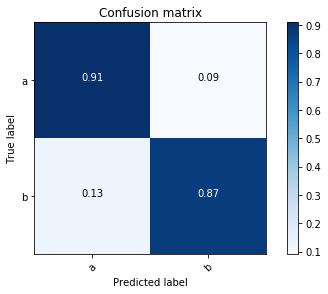

In [230]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['a','b'], normalize=True)